In [115]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from scipy.io import wavfile
import scipy.signal as sp
from scipy.io.wavfile import write

In [2]:
Dats = np.fromfile("cap2.dat", dtype='uint8')

In [32]:
# la señales en crudo normalmente estan compuestas por una parte real e imaginaria y se trabaja con la magnitud de dicho numero
# imaginario 

MDats = Dats - 127.5
IDats = MDats[::2] + 1j*MDats[1::2]


In [33]:
nmax = len(Dats)/2 # como los datos son un vector el numero real de datos para cada tiempo se divide en 2
TD = 10.0
srate = nmax/TD

la fórmula para garantizar el numero de elementos respectivos la tiempos es:

$$ N = T * S_{rate} $$

Donde $T = 0.002s $  y $S_{rate} = 2.5x10^6 s^{-1}$ 

In [34]:
N0002s = 0.002 * srate
f0 = 96e6 #centro de la frecuencia


In [35]:
fre, t, Ampli = signal.spectrogram(abs( IDats[:int(N0002s)]),srate) #frecuencia, tiempo amplitud
freC = (2*fre + f0 - srate/2)

In [36]:
p = np.fft.fftshift(np.fft.fft(IDats[:int(N0002s)])) # entrando en el espacio de frencuencias
Lp = abs(p) 

In [39]:
x = np.linspace(np.min(freC),np.max(freC),len(Lp)) 

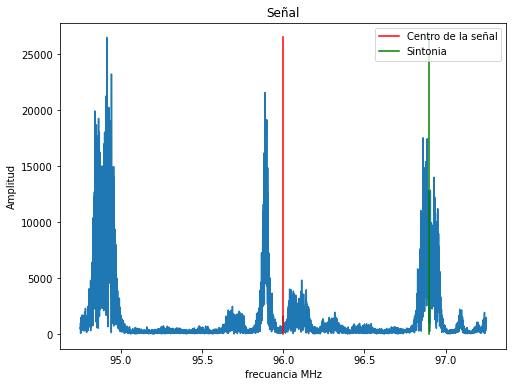

In [40]:
# se requiere sintonizar 96.9 Mhz en una emisora de radio 
plt.figure(figsize = (8,6))
plt.plot(x/1e6,np.abs(p))
plt.plot( [96,96],[np.max(np.abs(p)), np.min(np.abs(p))], "r-",label = "Centro de la señal" )
plt.plot( [96.9,96.9],[np.max(np.abs(p)), np.min(np.abs(p))], "g-", label = "Sintonia" )
plt.xlabel("frecuancia MHz")
plt.ylabel("Amplitud")
plt.title("Señal")
plt.legend()
plt.show()

In [41]:
fs = 96.9e6 #frecuencia sintonizada
BW = srate #ancho de banda 

Ss = np.zeros(int(len(IDats)), dtype = 'complex' )

for i in range(len(IDats)):
    Ss[i] = IDats[i]*np.exp(-1j*2*np.pi*i*((fs - f0)/BW) )

In [119]:
len(Ss) 

25000000

In [51]:
Sr_tf =  np.fft.fftshift(np.fft.fft(Ss[:int(N0002s)]))

t = np.arange(N0002s)/srate

Asr = abs(Sr_tf)
dBS = 20*np.log10(Asr/np.max(Asr))
freq = np.arange(fs-srate/2,fs+srate/2,srate/t.size) 

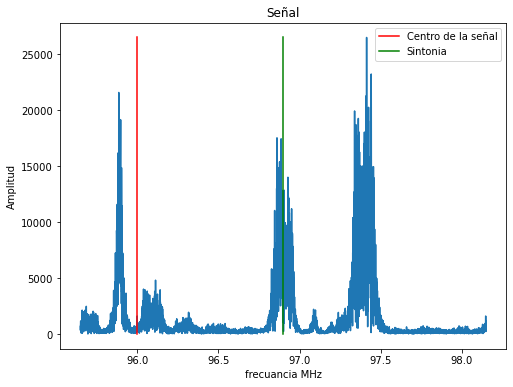

In [53]:
# se reubica el centro de la señal
plt.figure(figsize = (8,6))
plt.plot(freq/1e6,Asr)
plt.plot( [96,96],[np.max(Asr), np.min(Asr)], "r-",label = "Centro de la señal" )
plt.plot( [96.9,96.9],[np.max(Asr), np.min(Asr)], "g-", label = "Sintonia" )
plt.xlabel("frecuancia MHz")
plt.ylabel("Amplitud")
plt.title("Señal")
plt.legend()
plt.show()

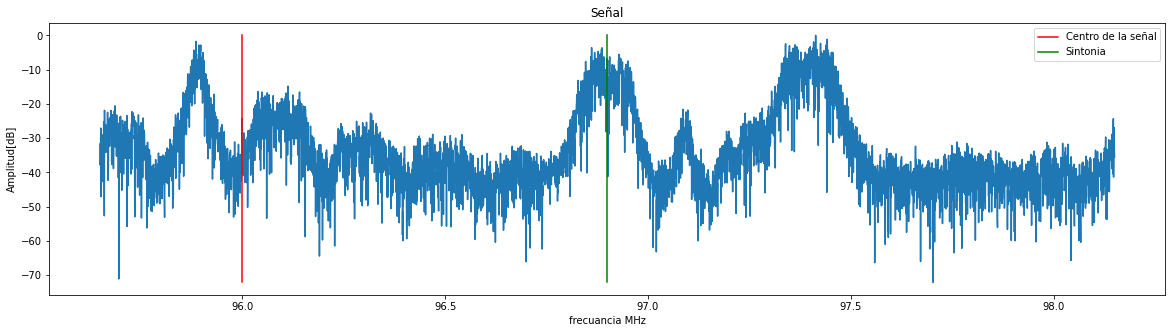

In [71]:
plt.figure(figsize = (20,5))
plt.plot(freq/1e6,dBS)
plt.plot( [96,96],[np.max(dBS), np.min(dBS)], "r-",label = "Centro de la señal" )
plt.plot( [96.9,96.9],[np.max(dBS), np.min(dBS)], "g-", label = "Sintonia" )
plt.xlabel("frecuancia MHz")
plt.ylabel("Amplitud[dB]")
plt.title("Señal")
plt.legend()
plt.show()

## Decimación 

si el srate es 1/10, como se vio en la primera formula el numero de datos es ahora $\frac{N_{dat}}{10}$, en general 

$ N_{dat} = S_{rateD}* t = \frac{S_{rateO} * t}{b} = \frac{N_{datO}}{b}  $

Donde $N_dat$ es el numero de datos posterior a la decimación y $N_{datO}$ es le numero de datos sin decimar. Y b es el nuemro de datos decimados.

In [90]:
# la decimación sirve como filtro de ruido en la señal, un paso primordial para poder tener claridad en el objetivo que es 
# sintonizar la radio.

Sdeci = sp.decimate(Ss , 10, ftype='fir')

BW10 = srate/10
N0002sD= int(N0002s/10)
SDFT = np.fft.fftshift(np.fft.fft(Sdeci[:N0002sD]))

tD = np.arange(N0002sD)/(BW10)

frecD = np.arange(fs - BW10/2,fs + BW10/2, BW10/tD.size)

LSDFT = abs(SDFT)

dBLSDFT = 20*np.log10(LSDFT/np.max(LSDFT))

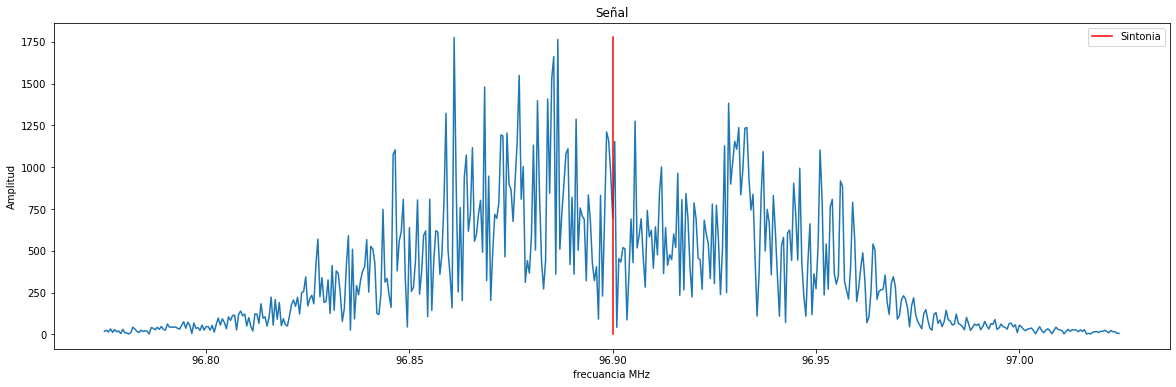

In [91]:
# region sintonizada y filtrado despues de decimar
plt.figure(figsize = (20,6))
plt.plot(frecD/1e6,LSDFT)
plt.plot( [96.9,96.9],[np.max(LSDFT), np.min(LSDFT)], "r-", label = "Sintonia" )
plt.xlabel("frecuancia MHz")
plt.ylabel("Amplitud")
plt.title("Señal")
plt.legend()
plt.show()

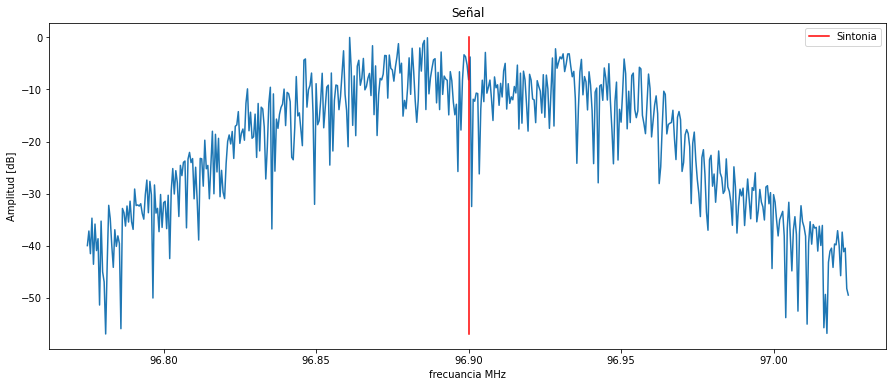

In [95]:
plt.figure(figsize = (15,6))
plt.plot(frecD/1e6,dBLSDFT)
plt.plot( [96.9,96.9],[np.max(dBLSDFT), np.min(dBLSDFT)], "r-", label = "Sintonia" )
plt.xlabel("frecuancia MHz")
plt.ylabel("Amplitud [dB]")
plt.title("Señal")
plt.legend()
plt.show()

# Demodulación

In [96]:
SDC = Sdeci.conjugate()

AnSDC = np.zeros(len(SDC))

for i in range(len(SDC)):
    AnSDC[i] = np.angle(Sdeci[i]*SDC[i-1], deg = False)

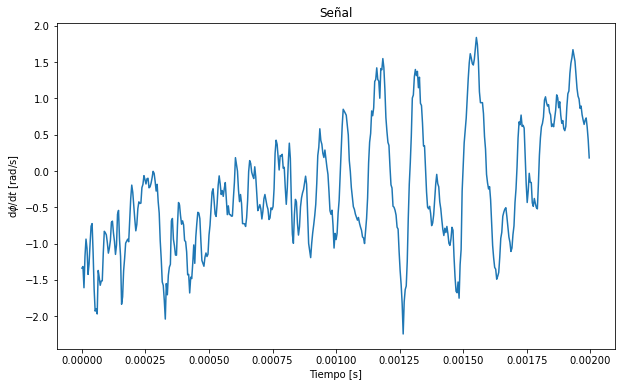

In [97]:
plt.figure(figsize = (10,6))
plt.plot(tD,AnSDC[:500])
plt.xlabel("Tiempo [s]")
plt.ylabel('d$\phi/$d$t$ [rad/s]')
plt.title("Señal")
plt.show()

# Espectro de la señal 

In [98]:
ftAnSDC = np.fft.fftshift(np.fft.fft(AnSDC[:500]))

LftAnSDC = abs(ftAnSDC)

dBAnSDC = 20*np.log10(LftAnSDC/np.max(LftAnSDC))

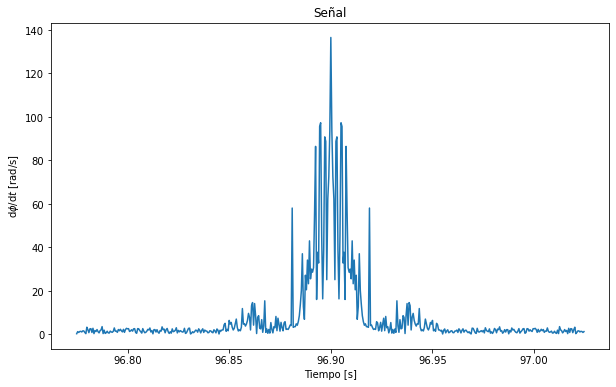

In [99]:
plt.figure(figsize = (10,6))
plt.plot(frecD/1e6,LftAnSDC)
plt.xlabel("Tiempo [s]")
plt.ylabel('amplitud')
plt.title("Señal")
plt.show()

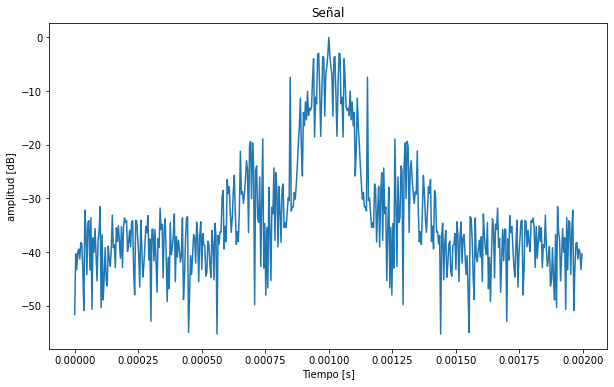

In [108]:
plt.figure(figsize = (10,6))
plt.plot(tD,dBAnSDC)
plt.xlabel("Tiempo [s]")
plt.ylabel('amplitud [dB]')
plt.title("Señal")
plt.show()

# Decimación 

In [129]:
AND = sp.decimate (AnSDC, q = 10, ftype = 'fir')

NBW = BW10/10

N0002sN = NBW*0.002

ANDft = np.fft.fftshift(np.fft.fft(AND[:int(N0002sN)]))
frecN = np.arange(fs-NBW/2,fs+NBW/2,NBW/N0002sN)

LAND  = abs(ANDft)
dBAND = 20*np.log10(LAND/np.max(LAND))

In [132]:
NBW

25000.0

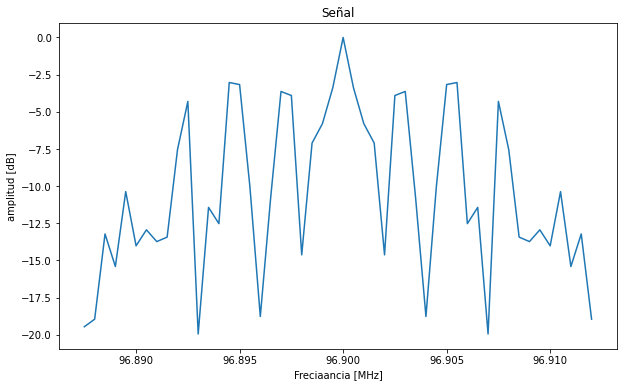

In [131]:
plt.figure(figsize = (10,6))
plt.plot(frecN/1e6,dBAND)
plt.xlabel("Freciaancia [MHz]")
plt.ylabel('amplitud [dB]')
plt.title("Señal")
plt.show()

# Conversión a audio 

In [113]:
w = (AND - np.min(AND))*255/(np.min(AND)- np.max(AND))
ANDu = w.astype(np.uint8)

In [133]:
write('audio.wav', int(NBW), ANDu)